# CSE4088 Machine Learning

## Göksel Tokur - 150116049

## Merve Ayer - 150119828

In [1]:
import pandas as pd
import os
import time
from datetime import timedelta, datetime
from dateutil import parser
import math
from tqdm import tqdm_notebook
import numpy as np
from sklearn.preprocessing import MinMaxScaler

## Read Collected Data from CSV

In [2]:
df = pd.read_csv('data/BTCUSDT-1m-1Jan2018to1Dec2020data.csv')
df.head()

df.tail(10)

,Timestamp,Open,High,Low,Close,Volume,Close_time,Quote_av,Trades,Tb_base_av,Tb_quote_av,Ignore
1526889,2020-11-30 23:51:00,19739.21,19744.99,19730.00,19743.99,90.702033,1606780319999,1.790549e+06,1185,51.236309,1.011530e+06,0
1526890,2020-11-30 23:52:00,19744.00,19744.99,19740.22,19744.48,60.573448,1606780379999,1.195970e+06,986,41.370690,8.168287e+05,0
1526891,2020-11-30 23:53:00,19744.49,19744.99,19699.52,19718.28,119.123054,1606780439999,2.349155e+06,1683,68.558198,1.351917e+06,0
1526892,2020-11-30 23:54:00,19718.28,19736.03,19625.05,19641.37,97.284917,1606780499999,1.915027e+06,2217,37.528715,7.392528e+05,0
1526893,2020-11-30 23:55:00,19641.37,19697.58,19637.04,19663.31,112.950287,1606780559999,2.221748e+06,2162,65.823884,1.294934e+06,0
1526894,2020-11-30 23:56:00,19663.25,19672.28,19635.00,19656.01,80.342827,1606780619999,1.579052e+06,1776,34.951323,6.869545e+05,0
1526895,2020-11-30 23:57:00,19656.01,19686.37,19650.00,19655.99,58.163503,1606780679999,1.143874e+06,1151,29.788851,5.858160e+05,0
1526896,2020-11-30 23:58:00,19656.10,19679.00,19647.83,19658.33,84.698943,1606780739999,1.665254e+06,1482,31.676067,6.227900e+05,0
1526897,2020-11-30 23:59:00,19658.33,19700.00,19656.82,19695.87,136.845571,1606780799999,2.693831e+06,1708,95.473753,1.879199e+06,0
1526898,2020-12-01 00:00:00,19695.87,19720.00,19675.43,19715.93,136.104435,1606780859999,2.681137e+06,1828,72.113618,1.420672e+06,0


In [3]:
# Check is there a missing value
print('Is there a missing value? - ',df.isnull().values.any())

Is there a missing value? -  False


In [4]:
# Drop columns that we won't use
df = df.drop('Close_time', 1)
df = df.drop('Quote_av', 1)
df = df.drop('Trades', 1)
df = df.drop('Tb_base_av', 1)
df = df.drop('Tb_quote_av', 1)
df = df.drop('Ignore', 1)

df.tail(10)

,Timestamp,Open,High,Low,Close,Volume
1526889,2020-11-30 23:51:00,19739.21,19744.99,19730.00,19743.99,90.702033
1526890,2020-11-30 23:52:00,19744.00,19744.99,19740.22,19744.48,60.573448
1526891,2020-11-30 23:53:00,19744.49,19744.99,19699.52,19718.28,119.123054
1526892,2020-11-30 23:54:00,19718.28,19736.03,19625.05,19641.37,97.284917
1526893,2020-11-30 23:55:00,19641.37,19697.58,19637.04,19663.31,112.950287
1526894,2020-11-30 23:56:00,19663.25,19672.28,19635.00,19656.01,80.342827
1526895,2020-11-30 23:57:00,19656.01,19686.37,19650.00,19655.99,58.163503
1526896,2020-11-30 23:58:00,19656.10,19679.00,19647.83,19658.33,84.698943
1526897,2020-11-30 23:59:00,19658.33,19700.00,19656.82,19695.87,136.845571
1526898,2020-12-01 00:00:00,19695.87,19720.00,19675.43,19715.93,136.104435


In [5]:
'''
from sklearn.preprocessing import MinMaxScaler


#Columns of price data to use
columns = ['Close', 'Open', 'High', 'Low', 'Volume']

scaler = MinMaxScaler()
# normalization
for c in columns:
    df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))
    
df.tail(10)
'''

"\nfrom sklearn.preprocessing import MinMaxScaler\n\n\n#Columns of price data to use\ncolumns = ['Close', 'Open', 'High', 'Low', 'Volume']\n\nscaler = MinMaxScaler()\n# normalization\nfor c in columns:\n    df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))\n    \ndf.tail(10)\n"

# Sampling

In [6]:
# Produce training samples to predict future from past.
def sampler(P, F, A, sliding_window=True):
    number_of_samples = P + F
    
    if sliding_window:
        I = np.arange(number_of_samples) + np.arange(A.shape[0] - number_of_samples + 1).reshape(-1, 1)
    else:
        if A.shape[0] % number_of_samples == 0:
            I = np.arange(number_of_samples) + np.arange(0, A.shape[0], number_of_samples).reshape(-1, 1)
        else:
            I = np.arange(number_of_samples) + np.arange(0, A.shape[0] - number_of_samples, number_of_samples).reshape(-1, 1)
            
    B = A[I].reshape(-1, number_of_samples * A.shape[1], A.shape[2])
    number_of_features = P * A.shape[1]
    sample_matrix = B[:, :number_of_features]
    target_matrix = B[:, number_of_features:]
    
    return sample_matrix, target_matrix


data_file = 'data/BTCUSDT-1m-1Jan2018to1Dec2020data.csv'
df = pd.read_csv(data_file)

# Drop columns that we won't use
df = df.drop('Close_time', 1)
df = df.drop('Quote_av', 1)
df = df.drop('Trades', 1)
df = df.drop('Tb_base_av', 1)
df = df.drop('Tb_quote_av', 1)
df = df.drop('Ignore', 1)

df.tail(10)

number_of_backwards = 256
number_of_forwards = 16

test_df = df[-(number_of_backwards + number_of_forwards):]

df = df[:len(df)-(number_of_backwards + number_of_forwards)]


print(df)
test_df

                   Timestamp      Open      High       Low     Close  \
0        2018-01-01 00:00:00  13715.65  13715.65  13681.00  13707.92   
1        2018-01-01 00:01:00  13707.91  13707.91  13666.11  13694.92   
2        2018-01-01 00:02:00  13682.00  13694.94  13680.00  13680.00   
3        2018-01-01 00:03:00  13679.98  13679.98  13601.00  13645.99   
4        2018-01-01 00:04:00  13645.98  13646.00  13576.28  13600.00   
...                      ...       ...       ...       ...       ...   
1526622  2020-11-30 19:24:00  19253.22  19287.63  19245.00  19279.67   
1526623  2020-11-30 19:25:00  19279.66  19300.00  19279.66  19295.01   
1526624  2020-11-30 19:26:00  19295.01  19310.00  19279.66  19309.51   
1526625  2020-11-30 19:27:00  19308.56  19310.00  19282.16  19291.61   
1526626  2020-11-30 19:28:00  19291.62  19300.00  19282.16  19295.53   

            Volume  
0         2.844266  
1         2.113138  
2         1.346411  
3        11.589417  
4        15.724566  
...      

,Timestamp,Open,High,Low,Close,Volume
1526627,2020-11-30 19:29:00,19295.54,19300.10,19293.21,19299.89,35.919617
1526628,2020-11-30 19:30:00,19299.89,19315.00,19200.77,19211.54,133.579779
1526629,2020-11-30 19:31:00,19211.55,19231.86,19200.88,19219.18,95.678271
1526630,2020-11-30 19:32:00,19219.18,19255.50,19216.35,19251.39,36.612857
1526631,2020-11-30 19:33:00,19252.36,19252.36,19225.10,19231.58,35.311294
...,...,...,...,...,...,...
1526894,2020-11-30 23:56:00,19663.25,19672.28,19635.00,19656.01,80.342827
1526895,2020-11-30 23:57:00,19656.01,19686.37,19650.00,19655.99,58.163503
1526896,2020-11-30 23:58:00,19656.10,19679.00,19647.83,19658.33,84.698943
1526897,2020-11-30 23:59:00,19658.33,19700.00,19656.82,19695.87,136.845571


In [7]:
columns = ['Close']
o_df = df
time_stamps = df['Timestamp']
df = df.loc[:,columns]
real_df = o_df.loc[:,columns]

real_df

,Close
0,13707.92
1,13694.92
2,13680.00
3,13645.99
4,13600.00
...,...
1526622,19279.67
1526623,19295.01
1526624,19309.51
1526625,19291.61


### Normalize The Data with MinMax Normalization

In [8]:
# Normalize the data with min - max normalization
scaler = MinMaxScaler()

for c in columns:
    df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))
    
df

,Close
0,0.632389
1,0.631610
2,0.630716
3,0.628677
4,0.625920
...,...
1526622,0.966364
1526623,0.967283
1526624,0.968152
1526625,0.967079


In [9]:


# Features are backward sample dimensions
close_data = np.array(df)[:,None,:]
print('A', close_data)

real_close_data = np.array(real_df)[:,None,:]
print('real_A', real_close_data)

time_stamps = np.array(time_stamps)[:,None,None]
print('time_stamps', time_stamps)

number_of_backwards = 256
number_of_forwards = 16

# Pass preprocessed close data to the sampler
X, y = sampler(number_of_backwards, number_of_forwards, close_data, sliding_window=False)
print('Data', X)
print('Labels', y)

# Pass timestamps to the sampler
backward_times, forward_times = sampler(number_of_backwards, number_of_forwards, time_stamps, sliding_window=False)

# Pass real close data to the sampler
real_X, real_Y = sampler(number_of_backwards, number_of_forwards, real_close_data, sliding_window=False)

real_close_data = np.array(real_df)
real_backwards = np.array(real_X)
real_forwards = np.array(real_Y)


A [[[0.63238919]]

 [[0.63160996]]

 [[0.63071564]]

 ...

 [[0.96815232]]

 [[0.96707938]]

 [[0.96731435]]]
real_A [[[13707.92]]

 [[13694.92]]

 [[13680.  ]]

 ...

 [[19309.51]]

 [[19291.61]]

 [[19295.53]]]
time_stamps [[['2018-01-01 00:00:00']]

 [['2018-01-01 00:01:00']]

 [['2018-01-01 00:02:00']]

 ...

 [['2020-11-30 19:26:00']]

 [['2020-11-30 19:27:00']]

 [['2020-11-30 19:28:00']]]
Data [[[0.63238919]
  [0.63160996]
  [0.63071564]
  ...
  [0.61263634]
  [0.61103772]
  [0.60967646]]

 [[0.61692929]
  [0.61510709]
  [0.61665056]
  ...
  [0.61601219]
  [0.61633108]
  [0.61936588]]

 [[0.62382127]
  [0.62406103]
  [0.62346222]
  ...
  [0.58995538]
  [0.59169426]
  [0.59169426]]

 ...

 [[0.91826189]
  [0.91766907]
  [0.91755459]
  ...
  [0.92800585]
  [0.92872154]
  [0.92950137]]

 [[0.92607096]
  [0.92518144]
  [0.92565977]
  ...
  [0.92831214]
  [0.92777268]
  [0.92685498]]

 [[0.93276633]
  [0.93380211]
  [0.93215554]
  ...
  [0.98205736]
  [0.98149331]
  [0.98142858]]]
La

In [10]:
import pandas as pd
import numpy as numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Dense, Activation, Dropout, Flatten, Conv1D, MaxPooling1D, LeakyReLU
from keras.utils import np_utils
from keras.callbacks import CSVLogger, ModelCheckpoint
import os
import tensorflow as tf


output_file_name = 'BTCUSDT-1m'

step_size = X.shape[1]
batch_size= 8
nb_features = X.shape[2]

epochs = 20

# Split training data and validation data %80 -> training
training_size = int(X.shape[0] * 0.8)
Xt = X[:training_size,:]
yt = y[:training_size,:]
Xv = X[training_size:,:]
yv = y[training_size:,:]


# Neural Network
model = Sequential()


# 2 layers
print((step_size, nb_features))
model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=3, filters=8, kernel_size=20))
model.add(Dropout(0.25))
model.add(Conv1D( strides=4, filters=nb_features, kernel_size=16))


'''
# 3 Layers
model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=3, filters=8, kernel_size=8))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=8))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D( strides=2, filters=nb_features, kernel_size=8))

# 4 layers
model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=2, filters=8, kernel_size=2))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=2))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=2))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D( strides=2, filters=nb_features, kernel_size=2))
'''

model.compile(loss='mse', optimizer='adam')
model.fit(Xt, yt, verbose=1, batch_size=batch_size, validation_data=(Xv, yv), epochs = epochs, callbacks=[CSVLogger(output_file_name+'.csv', append=True), ModelCheckpoint('models/'+'best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')])


Using TensorFlow backend.


(256, 1)
Epoch 1/20
562/562 [==============================] - 3s 4ms/step - loss: 0.0123 - val_loss: 9.6133e-05

Epoch 00001: val_loss improved from inf to 0.00010, saving model to models/best_model.hdf5
Epoch 2/20
562/562 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 6.2455e-05

Epoch 00002: val_loss improved from 0.00010 to 0.00006, saving model to models/best_model.hdf5
Epoch 3/20
562/562 [==============================] - 1s 2ms/step - loss: 9.1541e-04 - val_loss: 6.7653e-05

Epoch 00003: val_loss did not improve from 0.00006
Epoch 4/20
562/562 [==============================] - 1s 2ms/step - loss: 7.8857e-04 - val_loss: 7.7325e-05

Epoch 00004: val_loss did not improve from 0.00006
Epoch 5/20
562/562 [==============================] - 1s 2ms/step - loss: 8.2496e-04 - val_loss: 4.4640e-05

Epoch 00005: val_loss improved from 0.00006 to 0.00004, saving model to models/best_model.hdf5
Epoch 6/20
562/562 [==============================] - 1s 2ms/step - los

# Load model

In [11]:
model.load_weights('models/best_model.hdf5')
model.compile(loss='mse', optimizer='adam')

# Change Variable Names

In [12]:
import matplotlib.pyplot as plt

# Split training data and validation data %80 -> training
training_size = int(X.shape[0] * 0.8)

close_data_val = X[training_size:,:,:]
print('close_data_val', close_data_val)
real_forwards_val = real_forwards[training_size:,:,:]
real_backwards_val = real_backwards[training_size:,:,:]
backward_times_val = backward_times[training_size:,:,:]
forward_times_val = forward_times[training_size:,:,:]



real_chart = np.append(real_backwards_val, real_forwards_val, axis=1)
print('real_chart', real_chart[0].shape,  (real_chart[0])[0].shape)
real_chart_times = np.append(backward_times_val, forward_times_val, axis=1)
print('real_chart_times', real_chart_times)


print('close_data_val' ,close_data_val[0].shape)
predicted = model.predict(close_data_val)
predicted_inverted = []
print('predicted', predicted)



# Inverse Transform (Min-Max Scaler)
for i in range(real_close_data.shape[1]):
    # 1D vector of the real data
    scaler.fit(real_close_data[:,i].reshape(-1,1))
    print('real_close_data[:,i]', real_close_data[:,i])
    predicted_inverted.append(scaler.inverse_transform(predicted[:,:,i]))
    print('predicted[:,:,i]', predicted[:,:,i])
    print('predicted_inverted', predicted_inverted)
    

# Get real_close values as 1D Vector
real_chart = real_chart[:,:,0].reshape(-1)
print('real_chart', real_chart)
real_chart_times = real_chart_times.reshape(-1)
print(real_chart_times)
real_chart_times = pd.to_datetime(real_chart_times, unit='ns')


print(np.array(predicted_inverted)[0].shape)
predicted_inverted = np.array(predicted_inverted)[0,:,:].reshape(-1)
print(np.array(predicted_inverted).shape)
forward_times_val = pd.to_datetime(forward_times_val.reshape(-1), unit='ns')

close_data_val [[[0.33850362]
  [0.33861511]
  [0.33910842]
  ...
  [0.34267789]
  [0.34309987]
  [0.34324013]]

 [[0.34389109]
  [0.34404753]
  [0.34439878]
  ...
  [0.34434903]
  [0.34333544]
  [0.34373824]]

 [[0.34238897]
  [0.34235121]
  [0.34241355]
  ...
  [0.34550769]
  [0.34491847]
  [0.34503835]]

 ...

 [[0.91826189]
  [0.91766907]
  [0.91755459]
  ...
  [0.92800585]
  [0.92872154]
  [0.92950137]]

 [[0.92607096]
  [0.92518144]
  [0.92565977]
  ...
  [0.92831214]
  [0.92777268]
  [0.92685498]]

 [[0.93276633]
  [0.93380211]
  [0.93215554]
  ...
  [0.98205736]
  [0.98149331]
  [0.98142858]]]
real_chart (272, 1) (1,)
real_chart_times [[['2020-05-02 09:20:00']
  ['2020-05-02 09:21:00']
  ['2020-05-02 09:22:00']
  ...
  ['2020-05-02 13:49:00']
  ['2020-05-02 13:50:00']
  ['2020-05-02 13:51:00']]

 [['2020-05-02 13:52:00']
  ['2020-05-02 13:53:00']
  ['2020-05-02 13:54:00']
  ...
  ['2020-05-02 18:21:00']
  ['2020-05-02 18:22:00']
  ['2020-05-02 18:23:00']]

 [['2020-05-02 18:24:

In [13]:
real_chart_df = pd.DataFrame()
real_chart_df['times'] = real_chart_times
real_chart_df['value'] = real_chart

prediction_df = pd.DataFrame()
prediction_df['times'] = forward_times_val
print(predicted_inverted)
prediction_df['value'] = predicted_inverted




[ 8806.923  8812.509  8818.948 ... 19530.398 19455.049 19388.34 ]


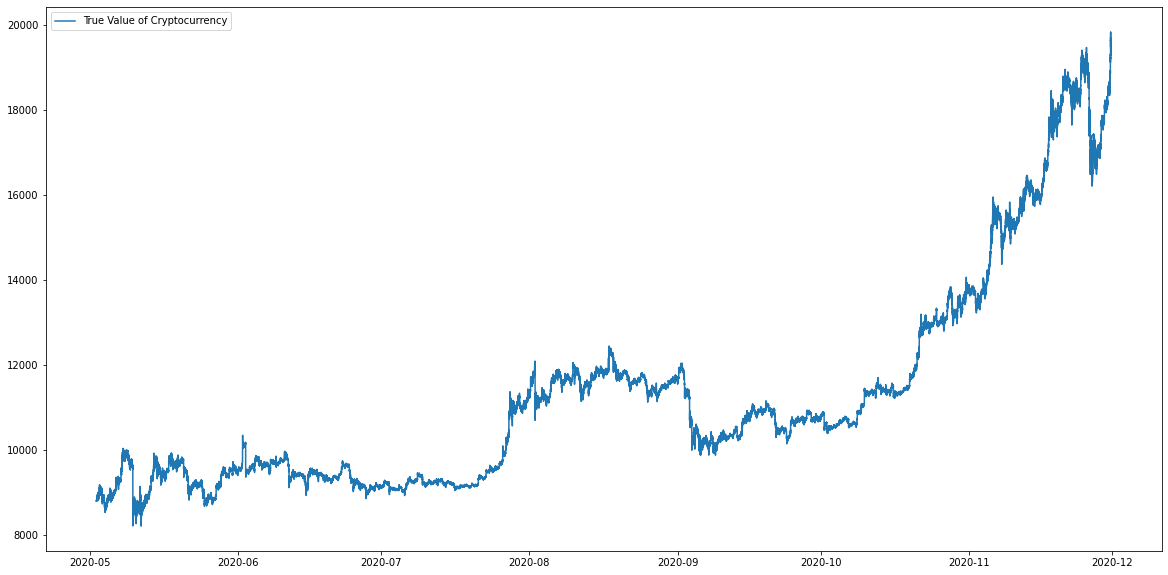

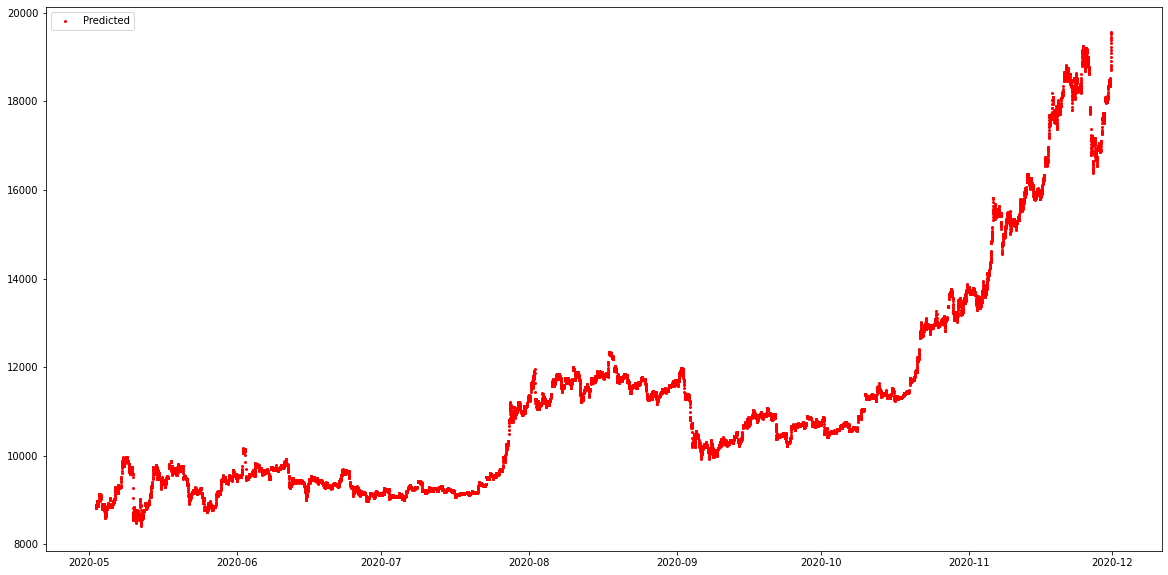

,times,value
17868,2020-11-29 12:30:00,18099.892578
17869,2020-11-29 12:31:00,18083.445312
17870,2020-11-29 12:32:00,18049.519531
17871,2020-11-29 12:33:00,18025.099609
17872,2020-11-29 16:50:00,17979.138672
...,...,...
17963,2020-11-30 16:41:00,19555.792969
17964,2020-11-30 16:42:00,19571.947266
17965,2020-11-30 16:43:00,19530.398438
17966,2020-11-30 16:44:00,19455.048828


In [14]:

plt.figure(figsize=(20,10))
plt.plot(real_chart_df.times, real_chart_df.value, label = 'True Value of Cryptocurrency')
plt.legend(loc='upper left')
plt.savefig('base.png')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(prediction_df.times, prediction_df.value, 'ro', label='Predicted', markersize=2)
plt.legend(loc='upper left')
plt.savefig('cnn.png')
plt.show()

prediction_df.tail(100)

In [15]:
real_chart_df

,times,value
0,2020-05-02 09:20:00,8804.98
1,2020-05-02 09:21:00,8806.84
2,2020-05-02 09:22:00,8815.07
3,2020-05-02 09:23:00,8808.48
4,2020-05-02 09:24:00,8808.35
...,...,...
305451,2020-11-30 16:41:00,19399.45
305452,2020-11-30 16:42:00,19373.20
305453,2020-11-30 16:43:00,19321.26
305454,2020-11-30 16:44:00,19340.00


In [16]:
# Get real_close_values
future_predict = pd.DataFrame(test_df['Close'])
columns = ['Close']
real_test_df = test_df.loc[:,columns]

real_future_predict = np.array(real_test_df)[:,None,:]

scaler = MinMaxScaler()
# Scale minmax transform
for c in columns:
    future_predict[c] = scaler.fit_transform(future_predict[c].values.reshape(-1,1))

# Get last backwards 256
future_predict = np.array([future_predict[:256]])
print('Backward input shape: ',future_predict[0].shape)

# Predict
predicted_future = model.predict(future_predict)

# Inverse Transform
predicted_future_inverted = []
for i in range(real_future_predict.shape[1]):
    print('RR', real_future_predict[:,i].reshape(-1, 1))
    scaler.fit(real_future_predict[:,i].reshape(-1, 1))
    predicted_future_inverted.append(scaler.inverse_transform(predicted_future[:,:,i]))
    

predicted_future_inverted = np.array(predicted_future_inverted)
print(predicted_future_inverted)

print((predicted_future_inverted[0])[0])
future_df = pd.DataFrame()
future_df['value'] =  (predicted_future_inverted[0])[0]

future_df



Backward input shape:  (256, 1)
RR [[19299.89]
 [19211.54]
 [19219.18]
 [19251.39]
 [19231.58]
 [19226.64]
 [19220.01]
 [19216.35]
 [19206.33]
 [19218.89]
 [19223.8 ]
 [19191.95]
 [19184.33]
 [19213.72]
 [19249.14]
 [19235.46]
 [19263.6 ]
 [19241.36]
 [19214.57]
 [19218.94]
 [19226.71]
 [19224.55]
 [19245.7 ]
 [19258.89]
 [19286.23]
 [19262.9 ]
 [19241.51]
 [19201.96]
 [19214.75]
 [19212.6 ]
 [19259.98]
 [19177.79]
 [19180.23]
 [19196.62]
 [19197.59]
 [19219.5 ]
 [19291.98]
 [19330.4 ]
 [19327.82]
 [19371.46]
 [19405.77]
 [19399.5 ]
 [19381.73]
 [19366.44]
 [19382.49]
 [19378.9 ]
 [19365.89]
 [19361.84]
 [19337.83]
 [19370.  ]
 [19369.8 ]
 [19367.12]
 [19399.6 ]
 [19383.4 ]
 [19382.68]
 [19376.56]
 [19366.74]
 [19383.91]
 [19405.86]
 [19422.17]
 [19417.03]
 [19429.67]
 [19392.84]
 [19396.8 ]
 [19435.02]
 [19439.  ]
 [19429.99]
 [19452.8 ]
 [19444.31]
 [19451.42]
 [19452.99]
 [19467.99]
 [19455.  ]
 [19437.53]
 [19412.53]
 [19427.19]
 [19425.77]
 [19413.96]
 [19415.87]
 [19391.05]
 [193

,value
0,19302.121094
1,19352.166016
2,19397.289062
3,19417.267578
4,19441.792969
5,19453.445312
6,19455.291016
7,19448.878906
8,19416.498047
9,19374.402344


In [17]:

'''
from datetime import datetime
from datetime import timedelta


last_date_of_the_graph = np.array(pd.to_datetime(o_df['Timestamp'], unit='ns'))[-1]

dt_obj = datetime.strptime(str(last_date_of_the_graph)[:-4], "%Y-%m-%dT%H:%M:%S.%f")
dt_obj

dates = []


dt_obj += timedelta(seconds=60)
for i in range(16):
    dates.append(datetime.timestamp(dt_obj))
    dt_obj += timedelta(seconds=60)

    
    
timess = pd.DataFrame()
timess['times'] = dates
#dates = pd.DataFrame(np.array(dates).reshape(-1))
#future_df['times'] = pd.to_datetime(dates, unit='ns')
timess['times']
'''


'\nfrom datetime import datetime\nfrom datetime import timedelta\n\n\nlast_date_of_the_graph = np.array(pd.to_datetime(o_df[\'Timestamp\'], unit=\'ns\'))[-1]\n\ndt_obj = datetime.strptime(str(last_date_of_the_graph)[:-4], "%Y-%m-%dT%H:%M:%S.%f")\ndt_obj\n\ndates = []\n\n\ndt_obj += timedelta(seconds=60)\nfor i in range(16):\n    dates.append(datetime.timestamp(dt_obj))\n    dt_obj += timedelta(seconds=60)\n\n    \n    \ntimess = pd.DataFrame()\ntimess[\'times\'] = dates\n#dates = pd.DataFrame(np.array(dates).reshape(-1))\n#future_df[\'times\'] = pd.to_datetime(dates, unit=\'ns\')\ntimess[\'times\']\n'

16
0    2020-11-30 23:45:00
1    2020-11-30 23:46:00
2    2020-11-30 23:47:00
3    2020-11-30 23:48:00
4    2020-11-30 23:49:00
5    2020-11-30 23:50:00
6    2020-11-30 23:51:00
7    2020-11-30 23:52:00
8    2020-11-30 23:53:00
9    2020-11-30 23:54:00
10   2020-11-30 23:55:00
11   2020-11-30 23:56:00
12   2020-11-30 23:57:00
13   2020-11-30 23:58:00
14   2020-11-30 23:59:00
15   2020-12-01 00:00:00
Name: timestamps, dtype: datetime64[ns]
AAAA
AAAA


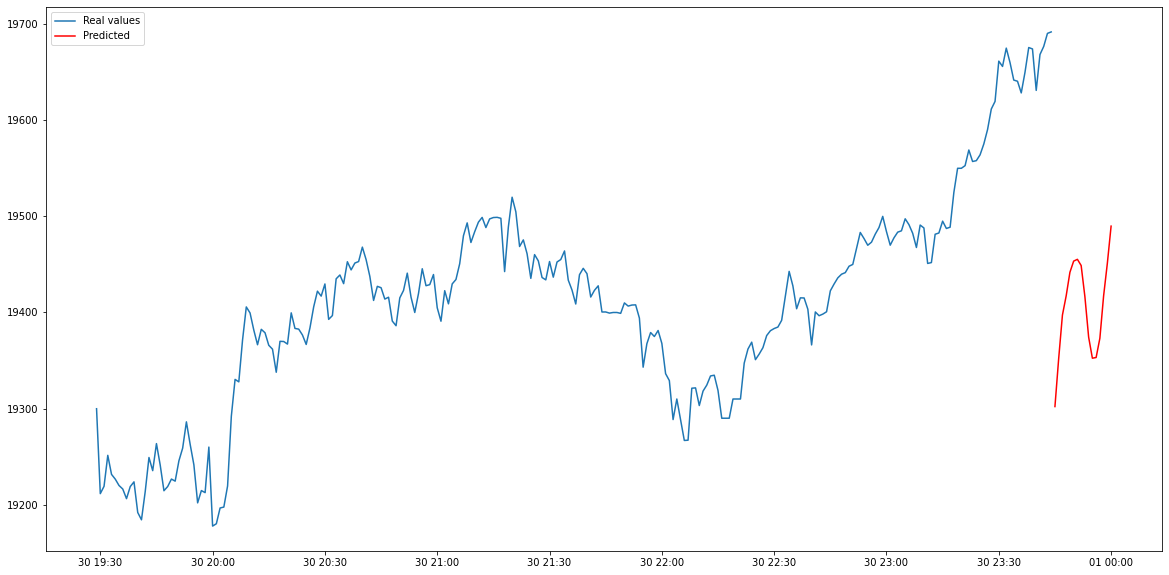

0    2020-11-30 23:45:00
1    2020-11-30 23:46:00
2    2020-11-30 23:47:00
3    2020-11-30 23:48:00
4    2020-11-30 23:49:00
5    2020-11-30 23:50:00
6    2020-11-30 23:51:00
7    2020-11-30 23:52:00
8    2020-11-30 23:53:00
9    2020-11-30 23:54:00
10   2020-11-30 23:55:00
11   2020-11-30 23:56:00
12   2020-11-30 23:57:00
13   2020-11-30 23:58:00
14   2020-11-30 23:59:00
15   2020-12-01 00:00:00
Name: timestamps, dtype: datetime64[ns]


In [18]:
o_df_2048 = test_df[:256]

real_8192 = pd.DataFrame()
real_8192['timestamps'] = pd.to_datetime(np.array(o_df_2048['Timestamp']).reshape(-1), unit='ns')
real_8192['close'] = np.array(o_df_2048['Close'])

o_df_512_256 = test_df[-16:]
print(len(o_df_512_256['Timestamp']))
time_512_256 = pd.DataFrame()
time_512_256['timestamps'] = pd.to_datetime(np.array(o_df_512_256['Timestamp']).reshape(-1), unit='ns')
print(time_512_256['timestamps'])
print("AAAA")

plt.figure(figsize=(20, 10))
print("AAAA")
plt.plot(real_8192.timestamps, real_8192.close, label='Real values')

#plt.plot(real_chart_df.times, real_chart_df.value, label = 'Actual')
plt.plot(time_512_256.timestamps, future_df.value, color='red', label='Predicted', markersize=2)
plt.legend(loc='upper left')
plt.savefig('cnn-Future.png')
plt.show()

prediction_df['times'][0]
print(time_512_256['timestamps'])

In [19]:
o_df.tail(256)

,Timestamp,Open,High,Low,Close,Volume
1526371,2020-11-30 15:13:00,19812.87,19863.16,19771.89,19840.83,630.383655
1526372,2020-11-30 15:14:00,19838.55,19860.00,19789.60,19811.10,278.309467
1526373,2020-11-30 15:15:00,19811.10,19829.98,19750.00,19766.10,246.148678
1526374,2020-11-30 15:16:00,19762.35,19780.20,19686.37,19764.39,319.337832
1526375,2020-11-30 15:17:00,19764.45,19810.22,19750.05,19804.00,188.757364
...,...,...,...,...,...,...
1526622,2020-11-30 19:24:00,19253.22,19287.63,19245.00,19279.67,47.113581
1526623,2020-11-30 19:25:00,19279.66,19300.00,19279.66,19295.01,63.166917
1526624,2020-11-30 19:26:00,19295.01,19310.00,19279.66,19309.51,83.665927
1526625,2020-11-30 19:27:00,19308.56,19310.00,19282.16,19291.61,56.956399
